## SQAE with DRC 

Trying the Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

2022-08-16 12:14:28.345233: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 12:14:28.345259: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Circuit

In [100]:
DATA_QBITS = 8
LATENT_QBITS = 2
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1

INPUT_DATA_SIZE = 16 # image width

DRCs = 2

In [101]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [102]:
def single_upload(params, data, wire):
    for i, d in enumerate(data.flatten()):
        if i % 3 == 0:
            qml.RX(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,img.shape[1]-kernel_size+1,stride)))*len(list(range(0,img.shape[0]-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,img.shape[1]-kernel_size+1,stride):
        for x in range(0,img.shape[0]-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1

def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])
        
def full_entanglement(wires):
    for i in range(len(wires)-1):
        for j in range(i+1,len(wires)):
            qml.CNOT(wires=[i,j])

def single_pool_layer(U, wires, params):
    wires_out = []
    for latent, pooled in zip(wires[:len(wires)//2],wires[len(wires)//2:]):
        U(params, wires=[pooled, latent])
        wires_out.append(latent)
    return wires_out
            
def single_conv_layer(U, wires, params):
    if len(wires) > 2:
        for i in wires[::2]:
            U(params, wires=[i, i+1])
        U(params, wires=[wires[0], wires[-1]])
        for i in wires[1:-1:2]:
            U(params, wires=[i, i+1])
    else:
        U(params, wires=[wires[0],wires[1]])
            
def conv_down(U, V, wires_in, wires_out, params, U_params, V_params):
    running_wires = wires_in
    params_used = 0
    while not running_wires == wires_out:
        single_conv_layer(U, running_wires, params[params_used: params_used + U_params])
        params_used = params_used + U_params
        running_wires = single_pool_layer(V, running_wires, params[params_used: params_used + V_params])
        params_used = params_used + V_params

def test_pool(params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])
    
def test_conv(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    
            
@qml.qnode(dev1)
def circuit(params, data):

    qml.AmplitudeEmbedding(data, wires=range(DATA_QBITS), normalize=True)i
    conv_down(test_conv, test_pool, list(range(DATA_QBITS)), list(range(LATENT_QBITS)), params, 4, 2)

    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

In [103]:
data = np.random.rand(INPUT_DATA_SIZE,INPUT_DATA_SIZE).flatten()

data_in = DATA_QBITS
data_out = LATENT_QBITS

num_reductions = int(np.log2(data_in / data_out))

num_params = 6 * num_reductions

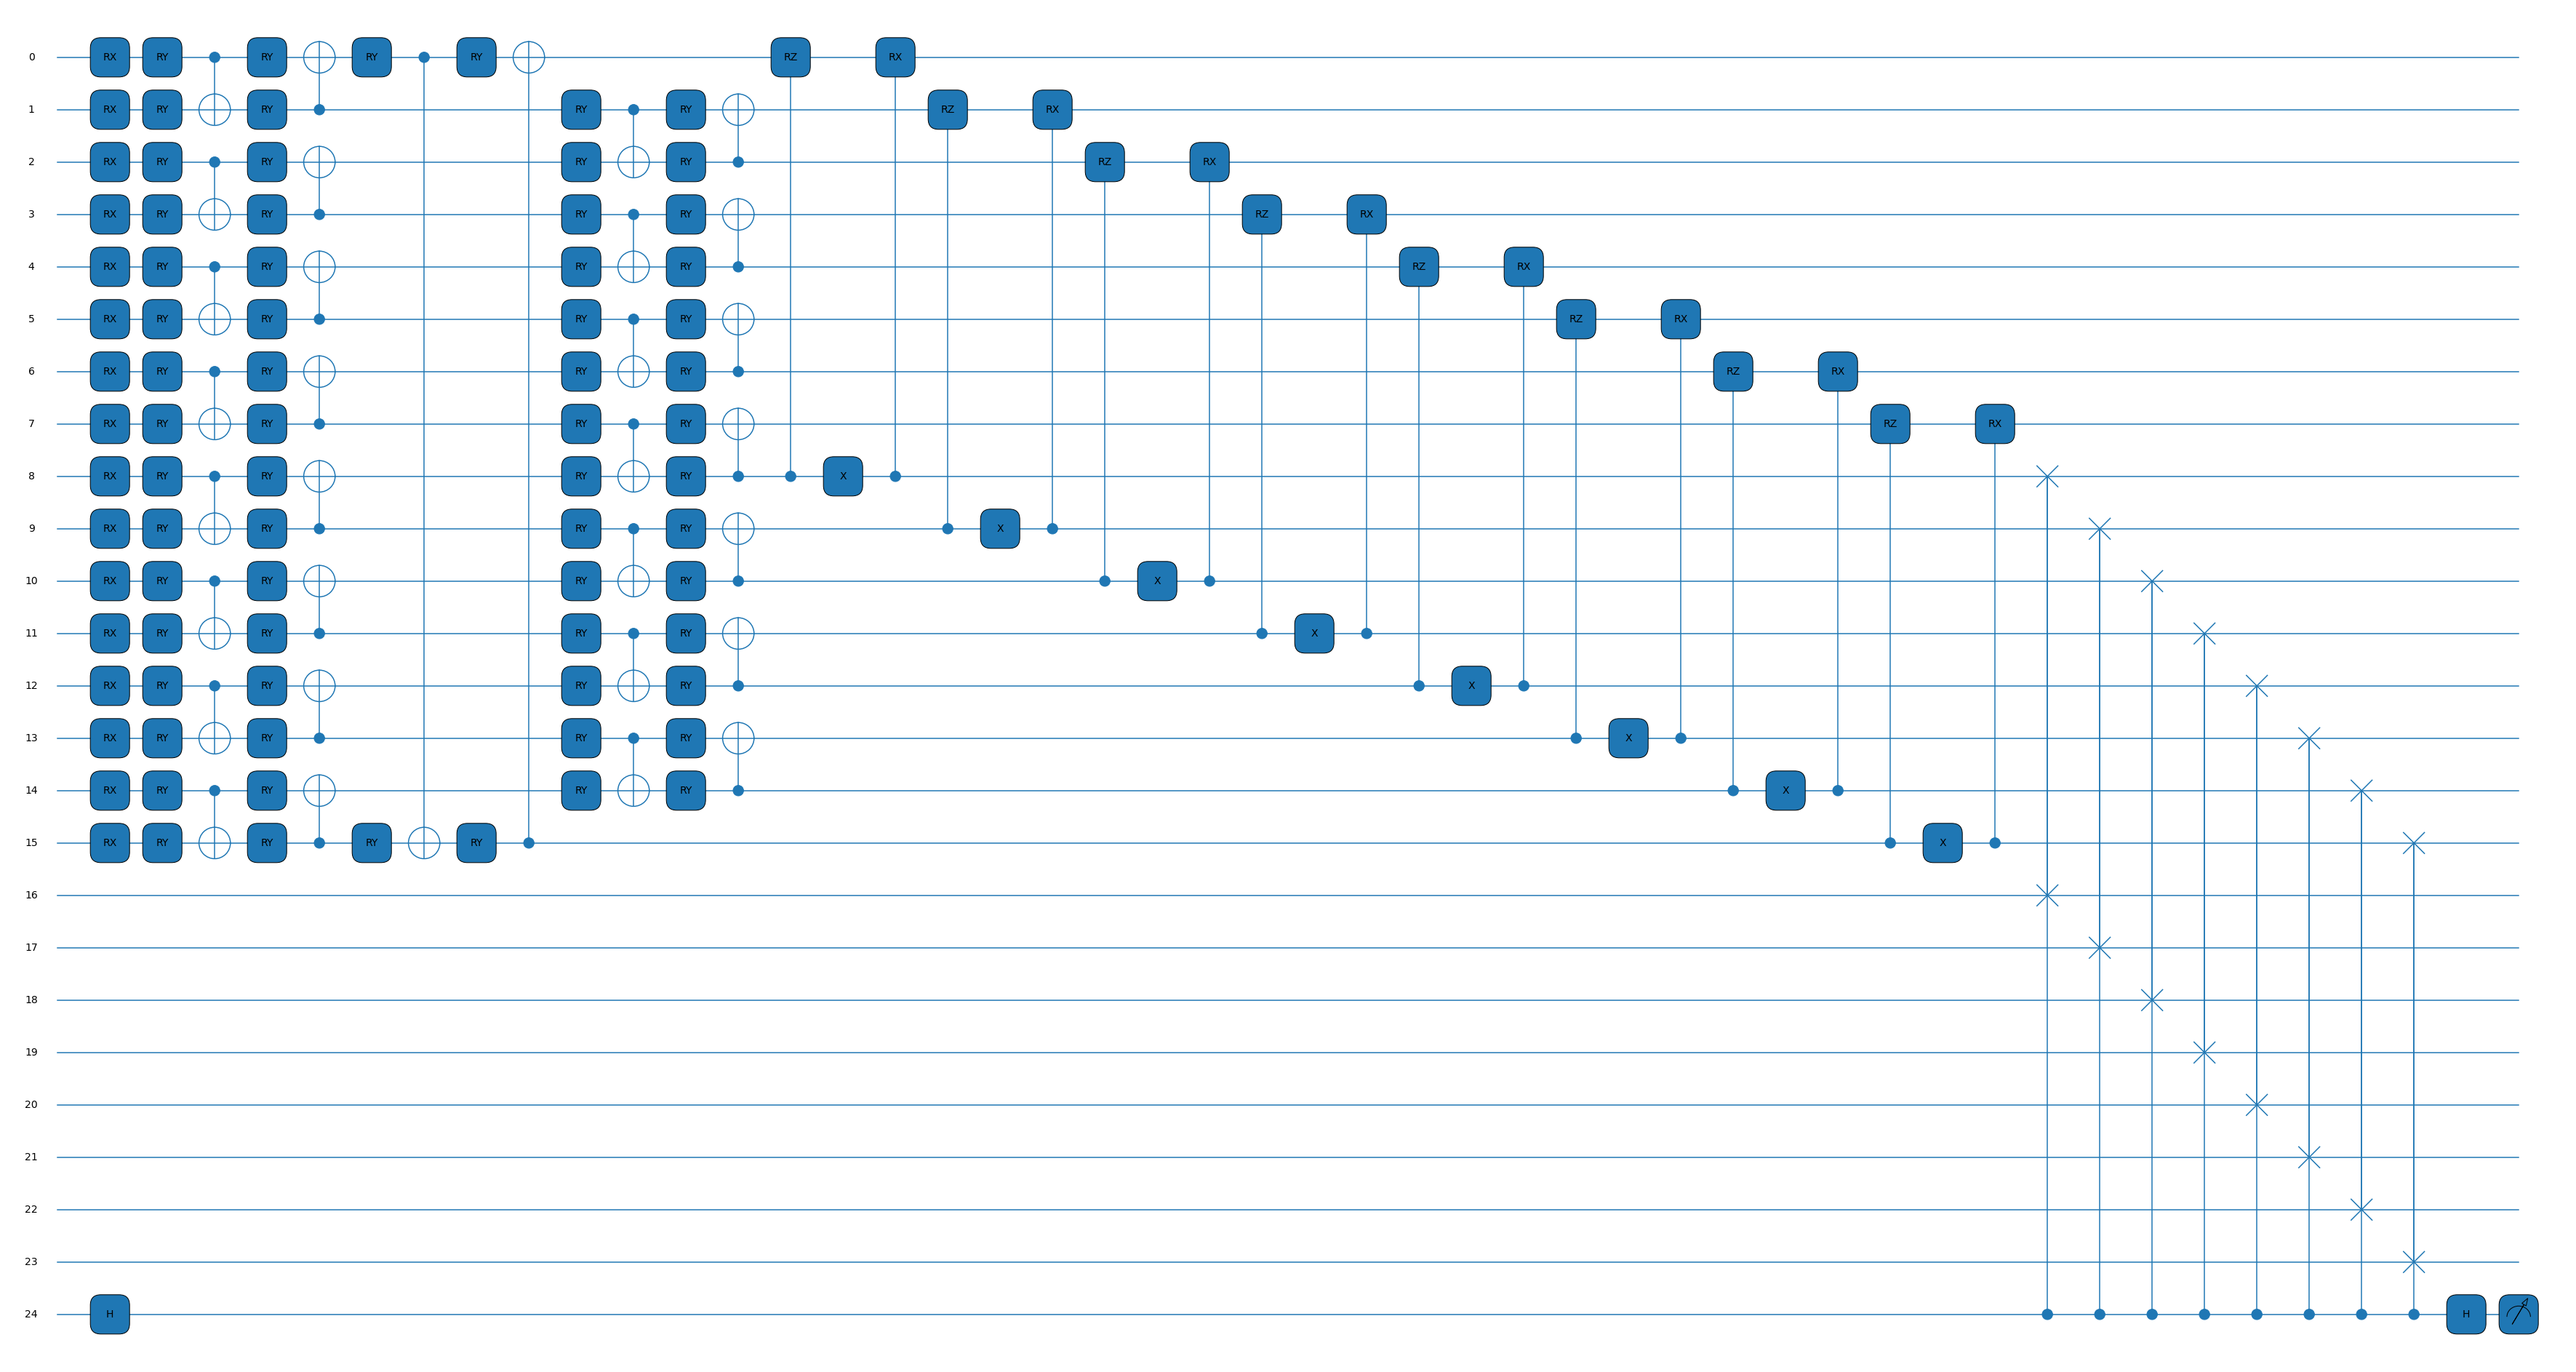

In [104]:
fig, ax = qml.draw_mpl(circuit)(np.ones(num_params),data)
fig.show()

## data 

In [105]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [106]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [107]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

x_train_threes = x_train_threes.reshape((x_train_threes.shape[0],x_train_threes.shape[1],x_train_threes.shape[2],1))
x_test_threes = x_test_threes.reshape((x_test_threes.shape[0],x_test_threes.shape[1],x_test_threes.shape[2],1))

In [108]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

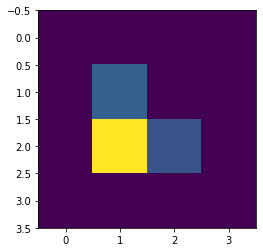

In [109]:
plt.imshow(x_train_small[5].reshape((x_train_small.shape[1],x_train_small.shape[2])))

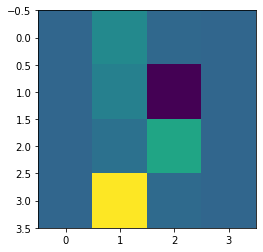

In [110]:
plt.imshow(x_train_3_small[7].reshape((x_train_3_small.shape[1],x_train_3_small.shape[2])))

In [111]:
x_train_small = x_train_small.reshape(x_train_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)
x_test_small = x_test_small.reshape(x_test_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)
x_test_3_small = x_train_3_small.reshape(x_train_3_small.shape[0],INPUT_DATA_SIZE*INPUT_DATA_SIZE)

## training

In [112]:
def cost_batch(params, batch):
    loss = 0.0
    for i in batch:
        f = circuit(params, i)
        loss = loss + (1 - f) ** 2
    return loss / len(batch)

def cost(params):
    loss = 0.0
    for i in range(len(x_train)):
        f = circuit(params, x_train[i])
        loss = loss + (1 - f) ** 2
    return loss / len(x_train)

def cost_sample(params, single_sample):
    return (1 - circuit(params, single_sample)) ** 2

In [113]:
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [114]:
learning_rate = 0.01
epochs = 2
batch_size = 25

In [115]:
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
#opt = qml.QNGOptimizer(learning_rate)
# opt = GradientDescentOptimizer(learning_rate)

In [116]:
weight_shapes = {"weights": (num_params)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [117]:
params.shape

(6,)

In [118]:
x_train_small = x_train_small[:1000]
x_test_small = x_test_small[:1000]
x_train_3_small = x_train_3_small[:1000]
x_test_3_small = x_test_3_small[:1000]

In [119]:
start = time.time()

for it in range(epochs):
    start_b = time.time()
    for j,Xbatch in enumerate(iterate_minibatches(x_train_small, batch_size=batch_size)):  
    #for j, sample in enumerate(x_train_small):        
        #sample = np.array(sample, requires_grad=False)
        #cost_fn = lambda p: cost_sample(p, sample)
        cost_fn = lambda p: cost_batch(p, Xbatch)
        #metric_fn = lambda p: qml.metric_tensor(circuit, approx="block-diag")(p, sample)
        params = opt.step(cost_fn, params)#, metric_tensor_fn=metric_fn)
        print(j, end="\r")
        if j % 20 == 0:
            end_b = time.time()
            loss = cost_batch(params,Xbatch)
            print(f"Step: {j} | Loss: {loss:.3} | avg step time {(end_b - start_b) / 100 :.3}")
            start_b = time.time()

    loss = cost_batch(params,x_train_small)
    val_loss = cost_batch(params, x_test_small)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3} | Val Loss {val_loss:.3}")
    print("____")
    
end = time.time()

print(f"Time for {epochs} epochs: {end - start}")


KeyboardInterrupt



In [ ]:
pred_six = np.array([circuit(params,i) for i in x_test_small])
np.mean(pred_six)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = np.array([circuit(params,i) for i in x_test_3_small])
np.mean(pred_three)
print("Median three reconstruciton fidelities: ",np.median(pred_three))

In [ ]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=50)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

AUC:  0.7571043841336116


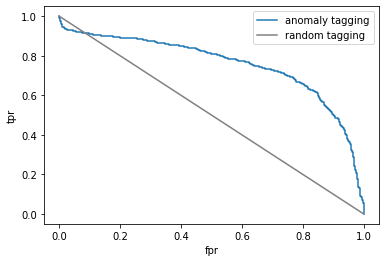

In [78]:
from sklearn.metrics import roc_auc_score, roc_curve

bce_background = 1-pred_six
bce_signal = 1-pred_three

y_true = np.append(np.zeros(len(bce_background)), np.ones(len(bce_signal)))
y_pred = np.append(bce_background, bce_signal)
auc = roc_auc_score(y_true, y_pred)

print("AUC: ", auc)

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
tnr = 1 - fpr
x = np.linspace(0,1,50)
y_rnd = 1 - x
plt.plot(tnr,tpr, label="anomaly tagging")
plt.plot(x,y_rnd, label="random tagging", color='grey')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

0.7293156281920327


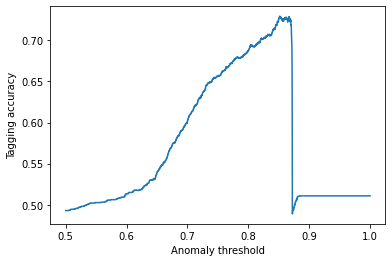

In [79]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0.5,1,9000)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  